# Libraries and data importing

Importing packages

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [55]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Importing data

In [3]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


Calculating the date 3 months ago from the last date in the data and filters the dataframe to include only the rows with dates greater than or equal to the date 3 months ago

In [4]:
thresholded_activities = (
    activities[activities['date'] >= activities['date'].max() - pd.DateOffset(months=3)]
    .groupby('contributor')
    .tail(300)
    .groupby(['category', pd.Grouper(key='date', freq='H'), 'contributor'])['activity']
    .count()
    .reset_index(name='n_activities')
    # keep data for contributors who have more than 10 different hour sequences
    .groupby('contributor')
    .filter(lambda x: len(x) >= 10)
)
thresholded_activities

,category,date,contributor,n_activities
0,bot,2023-01-15 16:00:00+00:00,AmplabJenkins,1
1,bot,2023-01-15 17:00:00+00:00,apollo-cla,1
2,bot,2023-01-15 17:00:00+00:00,stickler-ci[bot],1
3,bot,2023-01-15 18:00:00+00:00,AmplabJenkins,2
5,bot,2023-01-15 18:00:00+00:00,mysql-oca-bot,1
...,...,...,...,...
53322,human,2023-04-15 15:00:00+00:00,947579,6
53323,human,2023-04-15 16:00:00+00:00,387854,2
53324,human,2023-04-15 16:00:00+00:00,668373,1
53325,human,2023-04-15 16:00:00+00:00,784775,4


Filling n_activities with zeros for the empty hours between the minimum and maximum date for each contributor, and sets the category and contributor columns to a default values 

In [5]:
data = (
    thresholded_activities
    .groupby(['category','contributor'])
    .apply(
        lambda x: x
        .set_index('date')
        # resample data to fill in missing hours with zeros
        .resample('H')
        .sum()
        .fillna(0)
        .reset_index()
        # set the 'category' and 'contributor' columns to the values of the data group
        .assign(category=lambda y: y.iloc[0]['category'], contributor=lambda y: y.iloc[0]['contributor'])
        )
    .set_index('date')
    .rename_axis(None)
)
data

,category,contributor,n_activities
2023-01-18 10:00:00+00:00,bot,0crat,1
2023-01-18 11:00:00+00:00,bot,0crat,12
2023-01-18 12:00:00+00:00,bot,0crat,3
2023-01-18 13:00:00+00:00,bot,0crat,6
2023-01-18 14:00:00+00:00,bot,0crat,2
...,...,...,...
2023-04-06 05:00:00+00:00,human,999769,0
2023-04-06 06:00:00+00:00,human,999769,0
2023-04-06 07:00:00+00:00,human,999769,2
2023-04-06 08:00:00+00:00,human,999769,0


In [69]:
data[data['contributor'] == 'DrahtBot'].head(60)

,category,contributor,n_activities
2023-03-08 00:00:00+00:00,bot,DrahtBot,6
2023-03-08 01:00:00+00:00,bot,DrahtBot,0
2023-03-08 02:00:00+00:00,bot,DrahtBot,0
2023-03-08 03:00:00+00:00,bot,DrahtBot,0
2023-03-08 04:00:00+00:00,bot,DrahtBot,0
2023-03-08 05:00:00+00:00,bot,DrahtBot,0
2023-03-08 06:00:00+00:00,bot,DrahtBot,0
2023-03-08 07:00:00+00:00,bot,DrahtBot,0
2023-03-08 08:00:00+00:00,bot,DrahtBot,1
2023-03-08 09:00:00+00:00,bot,DrahtBot,2


# Autocorrelation function

In [70]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The optimal numer of lags is : 24


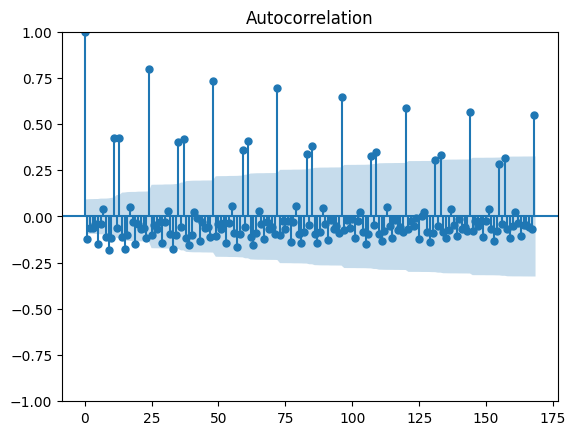

In [74]:
temp = data[data['contributor'] == 'pytorchbot']
lags = min(int((len(temp)/2)-1),168)

acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)

print('The optimal numer of lags is :', np.argmax(acf_values[1:])+1)

# Plot the autocorrelation function
plot_acf(temp['n_activities'].values, lags=lags)
plt.show()

The optimal numer of lags is : 168


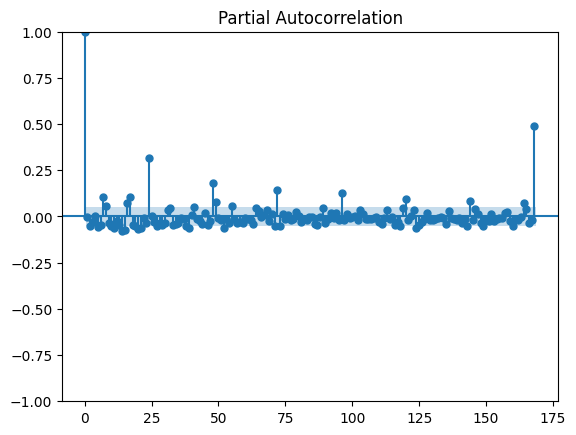

In [73]:
temp = data[data['contributor'] == 'lingohub[bot]']
lags = min(int((len(temp)/2)-1),168)

pacf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05, method='ols')

print('The optimal numer of lags is :', np.argmax(pacf_values[1:])+1)

# Plot the partial autocorrelation function
plot_pacf(temp['n_activities'].values, lags=lags)
plt.show()

# 1. Autoregressive model

Percentage of Predicted Values Greater Than or Equal to Actual Values (PPG), a new evaluation metric that calculates the percentage of predicted values greater than or equal to the actual values. We can define this metric as follows:

$$PGA = \frac{\sum_{i=1}^{n} [y_i \leq \hat{y}_i]}{n} \times 100$$

In [159]:
def pga_score(y_true, y_pred):
    return (y_pred >= y_true).mean()

Partial autocorrelation is a commonly used tool for identifying the order of an autoregressive model.

In [161]:
def ar_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    pacf_values, _ = pacf(train['n_activities'].values, nlags=lags, alpha=0.05, method='ols')
    optimal_lags = np.argmax(pacf_values[1:])+1

    # Fit the model
    model = AutoReg(train['n_activities'], lags=optimal_lags).fit()

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.01)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'mse': mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'pga_ci_upper': pga_score(test['n_activities'], predictions['mean_ci_upper']),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics


In [162]:
# Apply the function to each contributor
ar_results = data.groupby(['category', 'contributor']).apply(ar_model).reset_index(drop=True)

0crat
24emebot
5iMON-bot
AmplabJenkins
AppVeyorBot
ArduinoBot
CFPBot
Code-Inside-Bot
CrowdinBot
DrahtBot
Favware-bot
FlexGet-Bot
HT2Bot
Hibernate-CI
HitkoDev
ININ-TransifexAutomation
PJBot
PRB0t
ParadiseSS13-Bot
RiotTranslateBot
SpacemacsBot
SwiftLintBot
UberOpenSourceBot
VaporBot
addonsbot
adobe-bot
adoptopenjdk-github-bot
agones-bot
alluxio-bot
amp-owners-bot[bot]
ampproject-artifacts-bot
analysis-bot
angular-automatic-lock-bot[bot]
ansibot
apmmachine
apollo-cla
aporeto-bot
archzfs-bot
asf-ci
atlassian-cla-bot[bot]
authenticator-bot
aviary2-wf
aws-cdk-automation
aws-sdk-go-automation
babel-bot
backpackbot
backportbot-nextcloud[bot]
ballerina-bot
bedevere-bot
bits-bot
blathers-crl[bot]
blueprint-bot
bluespice-github-bot
boring-cyborg[bot]
bors-servo
bot-gradle
botcerts
bugsnagbot
build-travis-ci
callstack-bot
carsonbot
cb-sdk-robot
cf-gitbot
chainer-ci
cheminfo-bot
cla-bot-2021[bot]
cla-bot[bot]
cla-checker-service[bot]
cloudwanbot
cmsdmwmbot
codeclimate[bot]
codesandbox[bot]
confs-te

In [166]:
ar_results.sort_values(by='pga', ascending=False).head(40)

,contributor,category,r2,mae,mse,pga,pga_ci_upper,n_activities,optimal_lags
66,cla-bot[bot],bot,-1.062667e+07,2.269200e+03,1.741593e+07,1.000000,1.000000,300,157
55,bot-gradle,bot,-3.464105e+00,3.914536e+00,1.964206e+01,1.000000,1.000000,300,1
663,947579,human,-2.011014e+02,2.211022e+01,6.597525e+02,1.000000,1.000000,300,93
42,aws-cdk-automation,bot,-1.217436e+02,5.152150e+00,2.727636e+01,1.000000,1.000000,300,4
265,vscode-issue-tracker-bot,bot,0.000000e+00,4.766558e-15,2.290326e-29,1.000000,1.000000,300,1
234,sourcegraph-bot,bot,-3.920375e+01,2.245758e+00,6.432600e+00,1.000000,1.000000,300,1
688,978678,human,-2.263926e+11,4.171995e+05,1.111172e+12,1.000000,1.000000,300,121
218,rultor,bot,-5.298263e+01,9.008531e+00,1.185219e+02,1.000000,1.000000,300,44
211,renovate-approve-2[bot],bot,-2.497783e+01,7.394527e+00,5.611211e+01,1.000000,1.000000,300,1
446,586656,human,-3.437953e-01,1.463524e-01,5.599026e-02,0.995349,0.995349,263,1


In [167]:
ar_results.to_csv('../eval-rest/ar_model_metrics_ci.csv', index=False)

,count
optimal_lags,
1,337
24,40
2,24
168,14
25,11


<Axes: xlabel='optimal_lags', ylabel='count'>

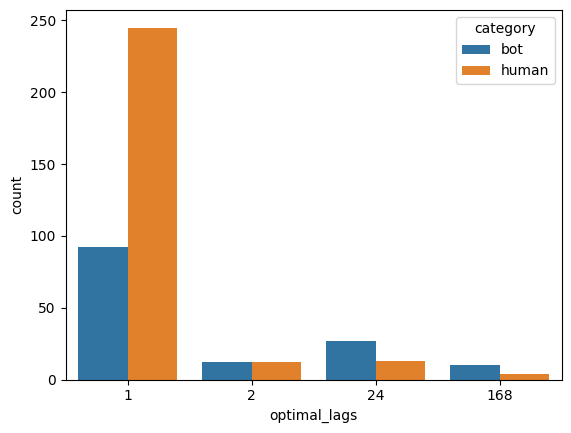

In [96]:
ar_results = pd.read_csv('../eval-rest/ar_model_metrics.csv')
display(ar_results['optimal_lags'].value_counts().to_frame().head())
sns.countplot(x='optimal_lags', hue='category', data=ar_results[ar_results['optimal_lags'].isin([1, 2, 24, 168])])

# 2. Moving-average model

In [ ]:
def ma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    optimal_lags = np.argmax(acf_values[1:])+1

    # Fit the model
    model = ARIMA(train['n_activities'], order=(0, 0, optimal_lags)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ma_results = data.groupby(['category', 'contributor']).apply(ma_model).reset_index(drop=True)

In [ ]:
ma_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
ma_results.to_csv('../eval-rest/ma_model_metrics.csv', index=False)

,count
optimal_lags,
24,707
2,10


<Axes: xlabel='optimal_lags', ylabel='count'>

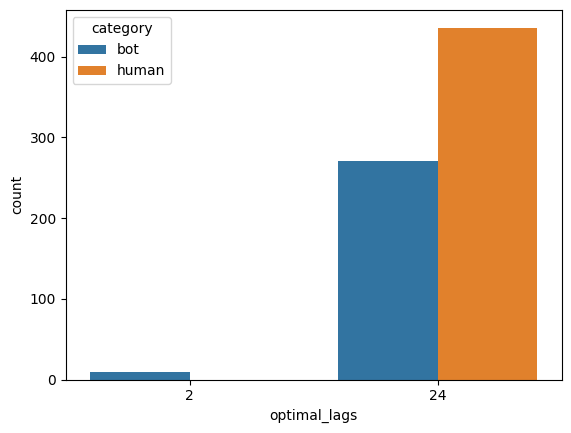

In [100]:
ma_results = pd.read_csv('../eval-rest/ma_model_metrics.csv')
display(ma_results['optimal_lags'].value_counts().to_frame().head())
sns.countplot(x='optimal_lags', hue='category', data=ma_results[ma_results['optimal_lags'].isin([2, 24])])

# 3. Autoregressive Moving-average model

In [ ]:
def arma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal parameters
    lags = min(int((len(train)/2)-1),24*7)

    pacf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    p = np.argmax(pacf_values[1:])+1

    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    q = np.argmax(acf_values[1:])+1

    print (p, q)

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 0, 1)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'p_order': p,
        'q_order': q
    })

    return print(metrics)

arma_model(data[data['contributor'] == 'lingohub[bot]'])

In [67]:
def arma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 0, 1)).fit(method='innovations_mle')

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
arma_results = data.groupby(['category', 'contributor']).apply(arma_model).reset_index(drop=True)

In [18]:
arma_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
265,vscode-issue-tracker-bot,bot,1.000000,0.000000,0.000000,300
700,983874,human,0.186275,1.333177,4.223043,300
342,437693,human,0.178478,3.557969,14.990240,300
404,543595,human,0.097790,1.005003,2.078143,300
228,skia-flutter-autoroll,bot,0.069756,2.213537,7.947272,300
317,376887,human,0.051406,0.588989,0.859382,300
46,backportbot-nextcloud[bot],bot,0.051304,1.326977,2.682679,300
702,985588,human,0.046739,0.778744,1.766587,300
27,agones-bot,bot,0.022325,0.455257,0.299956,300
92,edx-requirements-bot,bot,0.021934,4.031566,35.355877,300


In [19]:
arma_results.to_csv('../eval-rest/arma_model_metrics.csv', index=False)

# 4. Autoregressive integrated Moving-average model

In [96]:
def arima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 1, 1)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
arima_results = data.groupby(['category', 'contributor']).apply(arima_model).reset_index(drop=True)

In [98]:
arima_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
265,vscode-issue-tracker-bot,bot,1.000000,0.000000,0.000000,300
234,sourcegraph-bot,bot,0.195866,0.330433,0.128661,300
317,376887,human,0.067154,0.501659,0.845115,300
702,985588,human,0.047634,0.778684,1.764928,300
404,543595,human,0.022110,1.021995,2.252464,300
141,johnpbloch-bot,bot,0.017387,0.291847,0.759658,300
688,978678,human,0.015407,1.572113,4.832544,300
16,PJBot,bot,0.012763,0.456669,0.544218,300
180,nur-bot,bot,0.011310,1.531511,3.341948,300
585,797989,human,0.008063,1.811103,4.524742,300


In [99]:
arima_results.to_csv('../eval-rest/arima_model_metrics.csv', index=False)

# 5. Seasonal Autoregressive integrated Moving-average model

In [ ]:
import pmdarima as pm

def sarimax_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Use auto_arima to select the optimal seasonal_order parameter
    optimal_model = pm.auto_arima(train['n_activities'], seasonal=True, m=24)

    # Fit the model
    model = SARIMAX(train['n_activities'], order=optimal_model.order, seasonal_order=optimal_model.seasonal_order).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'order' : optimal_model.order,
        'seasonal_order' : optimal_model.seasonal_order
    })

    return print(metrics)

sarimax_model(data[data['contributor'] == 'lingohub[bot]'])

In [168]:
def sarima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = SARIMAX(train['n_activities'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False, enforce_stationarity=False).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
sarima_results = data.groupby(['category', 'contributor']).apply(sarima_model).reset_index(drop=True)

In [159]:
sarima_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
265,vscode-issue-tracker-bot,bot,1.000000,0.000000e+00,0.000000e+00,300
203,pxw-bot,bot,1.000000,6.301791e-07,1.196082e-11,180
181,octokit-fixture-user-a,bot,1.000000,3.858242e-06,4.052307e-10,300
7,Code-Inside-Bot,bot,0.997878,2.245156e-02,1.130119e-02,300
84,dontcallmedom-bot,bot,0.949912,1.855768e-01,5.241256e-01,300
204,pytorchbot,bot,0.913138,2.199351e-01,1.868500e-01,300
32,angular-automatic-lock-bot[bot],bot,0.893381,3.301472e-01,2.920989e+00,300
47,ballerina-bot,bot,0.812382,6.573424e-01,6.771834e-01,300
134,istio-policy-bot,bot,0.755105,2.764817e-01,2.205903e-01,300
259,usercont-release-bot,bot,0.749476,8.047926e-01,6.254830e+00,300


In [160]:
sarima_results.to_csv('../eval-rest/sarima_model_metrics.csv', index=False)

# 6. Unobserved components model

In [202]:
def uc_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = UnobservedComponents(train['n_activities'], level=True, seasonal=24).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
uc_results = data.groupby(['category', 'contributor']).apply(uc_model).reset_index(drop=True)

In [204]:
uc_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
203,pxw-bot,bot,1.000000,2.565620e-14,8.115989e-27,180
181,octokit-fixture-user-a,bot,1.000000,1.387779e-15,8.896344e-30,300
7,Code-Inside-Bot,bot,0.996559,2.615370e-02,1.833045e-02,300
32,angular-automatic-lock-bot[bot],bot,0.891698,4.527253e-01,2.967123e+00,300
204,pytorchbot,bot,0.882490,1.421757e-01,2.527773e-01,300
259,usercont-release-bot,bot,0.720489,7.979506e-01,6.978526e+00,300
84,dontcallmedom-bot,bot,0.704575,5.645001e-01,3.091329e+00,300
47,ballerina-bot,bot,0.591159,7.010871e-01,1.475662e+00,300
175,nextcloud-bot,bot,0.436033,8.209108e+00,1.386004e+02,300
100,facebook-circleci-bot,bot,0.249652,5.874078e-02,5.190630e-02,160


In [205]:
uc_results.to_csv('../eval-rest/uc_model_metrics.csv', index=False)

# 7. Simple exponential smoothing model

In [284]:
def ses_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = SimpleExpSmoothing(train['n_activities']).fit(smoothing_level=0.8, optimized=False, method='L-BFGS-B', remove_bias=True)

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ses_results = data.groupby(['category', 'contributor']).apply(ses_model).reset_index(drop=True)

In [286]:
ses_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
265,vscode-issue-tracker-bot,bot,1.000000,0.000000,0.000000,300
176,ninjadotorg-bot,bot,1.000000,0.000000,0.000000,300
10,Favware-bot,bot,-0.000041,0.011555,0.006024,15
206,r-ryantm,bot,-0.000064,1.013787,2.454239,300
628,885533,human,-0.000088,0.558315,1.717552,300
506,693537,human,-0.000149,0.285681,1.398167,97
532,745453,human,-0.000631,0.311690,0.520199,236
4,AppVeyorBot,bot,-0.000716,0.670274,0.600614,300
707,988439,human,-0.000917,0.520868,0.580576,300
105,forking-renovate[bot],bot,-0.001530,2.423993,17.857134,300


In [287]:
ses_results.to_csv('../eval-rest/ses_model_metrics.csv', index=False)

# 8. Holt’s linear (double) exponential smoothing model

In [312]:
def des_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = Holt(train['n_activities'], initialization_method='estimated').fit(method='L-BFGS-B')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
des_results = data.groupby(['category', 'contributor']).apply(des_model).reset_index(drop=True)

In [314]:
des_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
25,adobe-bot,bot,0.047993,1.151281e+00,1.428010e+00,300
206,r-ryantm,bot,0.040549,9.772385e-01,2.354572e+00,300
145,ks-ci-bot,bot,0.016804,1.341372e+00,3.702319e+00,300
55,bot-gradle,bot,0.008735,2.009884e+00,4.361564e+00,300
591,839443,human,0.003180,3.343558e-01,1.215381e+00,227
390,489458,human,0.002833,2.322111e-01,4.089893e-01,300
3,AmplabJenkins,bot,0.001979,3.340171e-01,6.928411e-01,28
293,353444,human,0.001835,2.075413e-01,2.741874e-01,256
454,597849,human,0.001630,4.806236e-01,6.033605e-01,300
0,0crat,bot,0.001540,3.618609e-02,4.537856e-02,118


In [315]:
des_results.to_csv('../eval-rest/des_model_metrics.csv', index=False)

# 9. Holt-Winters (triple) exponential smoothing model

In [359]:
def tes_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    try:
        model = ExponentialSmoothing(train['n_activities'], seasonal_periods=24, trend='add', seasonal='add').fit()
    except ValueError:
        model = ExponentialSmoothing(train['n_activities']).fit()
    except:
        print("Something else went wrong")

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [360]:
# Apply the function to each contributor
tes_results = data.groupby(['category', 'contributor']).apply(tes_model).reset_index(drop=True)

0crat
24emebot
5iMON-bot
AmplabJenkins
AppVeyorBot
ArduinoBot
CFPBot
Code-Inside-Bot
CrowdinBot
DrahtBot
Favware-bot
FlexGet-Bot
HT2Bot
Hibernate-CI
HitkoDev
ININ-TransifexAutomation
PJBot
PRB0t
ParadiseSS13-Bot
RiotTranslateBot
SpacemacsBot
SwiftLintBot
UberOpenSourceBot
VaporBot
addonsbot
adobe-bot
adoptopenjdk-github-bot
agones-bot
alluxio-bot
amp-owners-bot[bot]
ampproject-artifacts-bot
analysis-bot
angular-automatic-lock-bot[bot]
ansibot
apmmachine
apollo-cla
aporeto-bot
archzfs-bot
asf-ci
atlassian-cla-bot[bot]
authenticator-bot
aviary2-wf
aws-cdk-automation
aws-sdk-go-automation
babel-bot
backpackbot
backportbot-nextcloud[bot]
ballerina-bot
bedevere-bot
bits-bot
blathers-crl[bot]
blueprint-bot
bluespice-github-bot
boring-cyborg[bot]
bors-servo
bot-gradle
botcerts
bugsnagbot
build-travis-ci
callstack-bot
carsonbot
cb-sdk-robot
cf-gitbot
chainer-ci
cheminfo-bot
cla-bot-2021[bot]
cla-bot[bot]
cla-checker-service[bot]
cloudwanbot
cmsdmwmbot
codeclimate[bot]
codesandbox[bot]
confs-te

In [361]:
tes_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities
181,octokit-fixture-user-a,bot,1.000000,0.000000e+00,0.000000e+00,300
203,pxw-bot,bot,1.000000,4.609501e-16,2.843573e-31,180
7,Code-Inside-Bot,bot,0.997627,5.770554e-02,1.264052e-02,300
84,dontcallmedom-bot,bot,0.986465,2.448293e-01,1.416313e-01,300
204,pytorchbot,bot,0.935507,2.020598e-01,1.387326e-01,300
32,angular-automatic-lock-bot[bot],bot,0.857235,5.659841e-01,3.911281e+00,300
47,ballerina-bot,bot,0.850677,5.517068e-01,5.389611e-01,300
134,istio-policy-bot,bot,0.770222,2.393971e-01,2.069737e-01,300
259,usercont-release-bot,bot,0.738861,8.954009e-01,6.519838e+00,300
186,openhab-bot,bot,0.715637,1.138973e+00,3.369390e+00,300


In [362]:
tes_results.to_csv('../eval-rest/tes_model_metrics.csv', index=False)

# Long Short-Term Memory? why not